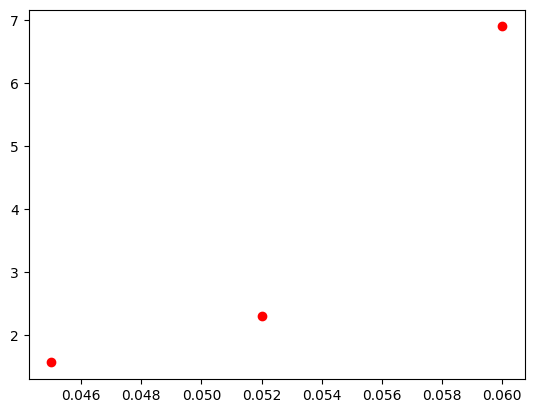

In [ ]:
import r3.schema as schema
import r3.adapters as adapters
from r3.models.assimulo import assimulo_model as ivt_model
import matplotlib.pyplot as plt

X_columns = [
    schema.IVTReactionSchema.NTP_M.value,
    schema.IVTReactionSchema.T7RNAP_u_uL.value,
    schema.IVTReactionSchema.DNA_ug_mL.value,
    schema.IVTReactionSchema.Mg2_M.value,
    schema.IVTReactionSchema.Spd_M.value,
    schema.IVTReactionSchema.TIME_min.value,
]

y_columns = [schema.IVTReactionSchema.RNA_g_L.value]

experimental_conditions, response = adapters.DataPipelineAdapter(
    "egfp_lhs", verbose=False
).get(
    X_columns=X_columns,
    y_columns=y_columns,
    paths_to_merge=[["csp_lhs", "Definitive Screening Design IVT"]],
)

model = ivt_model.AssimuloIVTModel(template=schema.DNATemplates.ANY)
predictions = model.predict_rna_yield(
    experimental_conditions=experimental_conditions,
    verbose=False,
)

# Plot the residuals of the model
residuals = (
    response[schema.IVTReactionSchema.RNA_g_L.value]
    - predictions[schema.IVTReactionSchema.RNA_g_L.value]
)

In [37]:
residuals

0    -2.110581
1    -0.550775
2     0.817837
3     0.925084
4     1.064080
        ...   
85    0.449169
86   -1.818165
87   -3.428033
88    3.221245
89    1.842167
Name: RNA [g/L], Length: 90, dtype: float64

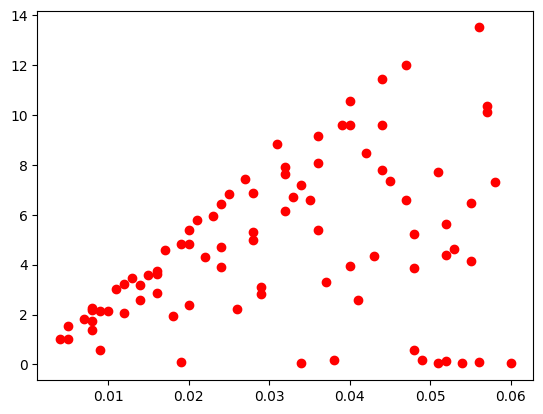

In [6]:
## remove the data points from the original data set where the residuals are less than -4
filtered_indices = residuals[residuals > -4].index
filtered_experimental_conditions = experimental_conditions.loc[filtered_indices]
filtered_response = response.loc[filtered_indices]
filtered_residuals = residuals.loc[filtered_indices]
plt.scatter(
    filtered_experimental_conditions[schema.IVTReactionSchema.NTP_M.value],
    filtered_response[schema.IVTReactionSchema.RNA_g_L.value],
    label="Filtered Data",
    color="red",
)

# Developing Machine Learning Part of the model


In [25]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel, WhiteKernel
import r3.adapters as adapters
from sklearn.model_selection import train_test_split

matern_kernel = ConstantKernel(1.0, (1e-2, 1e2)) * Matern(
    1.0, (1e-2, 1e2)
) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-3, 1e1))
gp_model = GaussianProcessRegressor(
    kernel=matern_kernel, n_restarts_optimizer=100, alpha=1e-2
)

X = filtered_experimental_conditions[X_columns].values
Y = filtered_response[y_columns].values
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# autoscaling the data
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
y_train = (y_train - y_train.mean(axis=0)) / y_train.std(axis=0)
y_test = (y_test - y_test.mean(axis=0)) / y_test.std(axis=0)

gp_model.fit(X_train, y_train)
adapters.evaluate_model(
    model=gp_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

{'r2': {'train': 0.9994638336576271, 'test': 0.8016569641553577},
 'mae': {'train': 0.017883604615718623, 'test': 0.309751968286361},
 'rmse': {'train': np.float64(0.0231552659749977),
  'test': np.float64(0.44535720028381975)}}

In [39]:
# train the Gp on the residuals now


matern_kernel = ConstantKernel(1.0, (1e-3, 1e1)) * RBF(1.0, (1e-3, 1e1))
gp_model = GaussianProcessRegressor(kernel=matern_kernel, n_restarts_optimizer=300)

X = filtered_experimental_conditions[X_columns].values
Y = filtered_residuals.values.reshape(-1, 1)  # Reshape for single output
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# autoscaling the data
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
y_train = (y_train - y_train.mean(axis=0)) / y_train.std(axis=0)
y_test = (y_test - y_test.mean(axis=0)) / y_test.std(axis=0)

gp_model.fit(X_train, y_train)
adapters.evaluate_model(
    model=gp_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

{'r2': {'train': 1.0, 'test': 0.5257569790121649},
 'mae': {'train': 1.025550403644772e-10, 'test': 0.504666851694145},
 'rmse': {'train': np.float64(1.379281240567899e-10),
  'test': np.float64(0.6886530483398989)}}

In [ ]:
# try the same with xgboost and random forest

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print(
    adapters.evaluate_model(
        model=rf_model,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
    )
)
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
print(
    adapters.evaluate_model(
        model=xgb_model,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
    )
)

{'r2': {'train': 0.8889501043500956, 'test': -0.061092091723942143}, 'mae': {'train': 0.2548571128092568, 'test': 0.7665962759160445}, 'rmse': {'train': np.float64(0.3332414974907903), 'test': np.float64(1.03009324418906)}}
{'r2': {'train': 0.9999993700257859, 'test': -0.7117620680249215}, 'mae': {'train': 0.0005235216226504688, 'test': 0.9843958068906365}, 'rmse': {'train': np.float64(0.0007937091495480203), 'test': np.float64(1.3083432531354002)}}


In [43]:
# Build discrepancy model combining the assimulo model and the GP model

matern_kernel = ConstantKernel(1.0, (1e-3, 1e1)) * RBF(1.0, (1e-3, 1e1))
gp_model = GaussianProcessRegressor(kernel=matern_kernel, n_restarts_optimizer=300)

# Use StandardScaler to scale the predictions
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler()
scalerY = StandardScaler()
X_scaled = scalerX.fit_transform(filtered_experimental_conditions[X_columns].values)
Y_scaled = scalerY.fit_transform(filtered_residuals.values.reshape(-1, 1))

## Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y_scaled, test_size=0.2, random_state=42
)

gp_model.fit(X_train, y_train)
adapters.evaluate_model(
    model=gp_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
)

{'r2': {'train': 1.0, 'test': 0.32215681318103895},
 'mae': {'train': 1.0421620560038934e-10, 'test': 0.5820143211137946},
 'rmse': {'train': np.float64(1.3984067273476306e-10),
  'test': np.float64(0.8156184459281252)}}